## name: Marco Giunta
### RLab07

In [1]:
library("tidyverse")

-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.3     v purrr   0.3.4
v tibble  3.1.0     v dplyr   1.0.5
v tidyr   1.1.3     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1

-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()



## Ex. 1: blood test
### 1.1: binomial likelihood
If $y$ is the number of times the test fails to detect the disease in the patients then we can model $y$ as being sampled from a binomial likelihood, whose bias parameter $p$ is unknown to us initially and to be determined via inference.       
### 1.2: frequentist estimate of $p$
If we want to use a frequentist approach given the binomial likelihood it suffices to use the following equation:
\begin{equation}
  p_f = \frac{y}{n}
\end{equation}
where $y/n=6/75$ is the number of ill patients whose disease wasn't noticed by the test (i.e. the fraction of false negatives).           
This works because $y/n$ is an unbiased estimator of $p_{\text{true}}$ in the frequentist setting, as can be easily shown:
\begin{equation}
  \mathbb{E} (p_f) = \mathbb{E}\left(\frac{y}{n}\right) = \frac{\mathbb{E}(y)}{n} = \frac{np}{n} = p   \implies |\mathbb{E}(p_f) - p| = 0
\end{equation}
where $p$ is the "true" unknown but fixed value whose existence is assumed in the frequentist setting.          
Notice: the fact that $p$ can be estimated this way is an intuitive result if we consider that a) each test is essentially a Bernoulli trial, and b) that probabilities in the frequentist approach are long run frequencies of the kind n. of successes/n. of attempts.

In [2]:
y <- 6
n <- 75
pf <- y/n

print(paste("frequentist estimate of p:", pf))

[1] "frequentist estimate of p: 0.08"


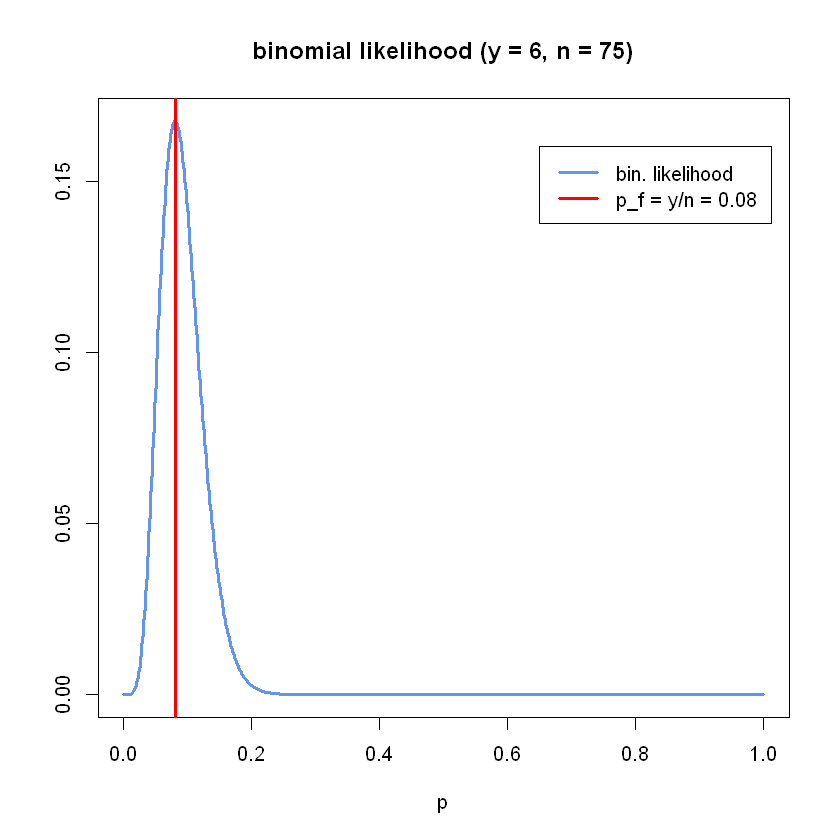

In [3]:
# notice that even if we didn't know the exact result mentioned above we could still obtain p_f
# using the MLE frequentist approach of finding the maximum of the likelihood. We don't actually 
# need to do it, though, because we already have an exact estimate of this number

p.vector <- seq(0, 1, length.out = 1000)
binomial.likelihood <- function(p, y = 6, n = 75) dbinom(x = y, size = n, prob = p)

plot(p.vector, binomial.likelihood(p.vector), type = "l", col = "cornflowerblue", xlab = "p", ylab = "", main = "binomial likelihood (y = 6, n = 75)", lwd = 3)
abline(v = pf, col = "red", lwd = 2.5)
legend(x = 0.65, y = 0.16, legend = c("bin. likelihood" , sprintf("p_f = y/n = %.2f", pf)), lty = c(1,1), col = c("cornflowerblue", "red"), lwd = c(3, 2.5))

Notice that the binomial unbiased estimator is none other than the argmax of the binomial likelihood.

### 1.3: Bayesian inference of $p$
This time we use Bayes' theorem in the standard way using the prior defined in the exercise: a beta prior with mean 0.15 and sd 0.14 (we can compute the $\alpha, \beta$ parameters associated to this value using the formulae and code contained [here](https://stats.stackexchange.com/questions/12232/calculating-the-parameters-of-a-beta-distribution-using-the-mean-and-variance)).         
Once we know the values of the prior's $\alpha$ and $\beta$ we can compute the posterior's parameters using the usual simple update rules, since a beta prior is conjugate to the binomial likelihood; this means the new $\alpha', \beta'$ are given by:
\begin{equation}
  \alpha' = \alpha + y
\end{equation}
\begin{equation}
  \beta' = \beta + n - y
\end{equation}

In [4]:
estBetaParams <- function(mu, var) {
  alpha <- ((1 - mu) / var - 1 / mu) * mu ^ 2
  beta <- alpha * (1 / mu - 1)
  return(params = list(alpha = alpha, beta = beta))
}

prior.params <- estBetaParams(mu = 0.15, var = 0.14^2)
alpha.prior <- prior.params$alpha; beta.prior <- prior.params$beta
print(paste("prior alpha, beta parameters = ", alpha.prior, "and", beta.prior))

[1] "prior alpha, beta parameters =  0.825765306122449 and 4.67933673469388"


In [5]:
alpha.posterior <- alpha.prior + y; beta.posterior <- beta.prior + n - y
print(paste("posterior alpha, beta parameters = ", alpha.posterior, "and", beta.posterior))

[1] "posterior alpha, beta parameters =  6.82576530612245 and 73.6793367346939"


[1] "most probable value for p (MAP estimator i.e. posterior mode) = 0.074"
[1] "posterior mean = 0.085, posterior var = 0.001"


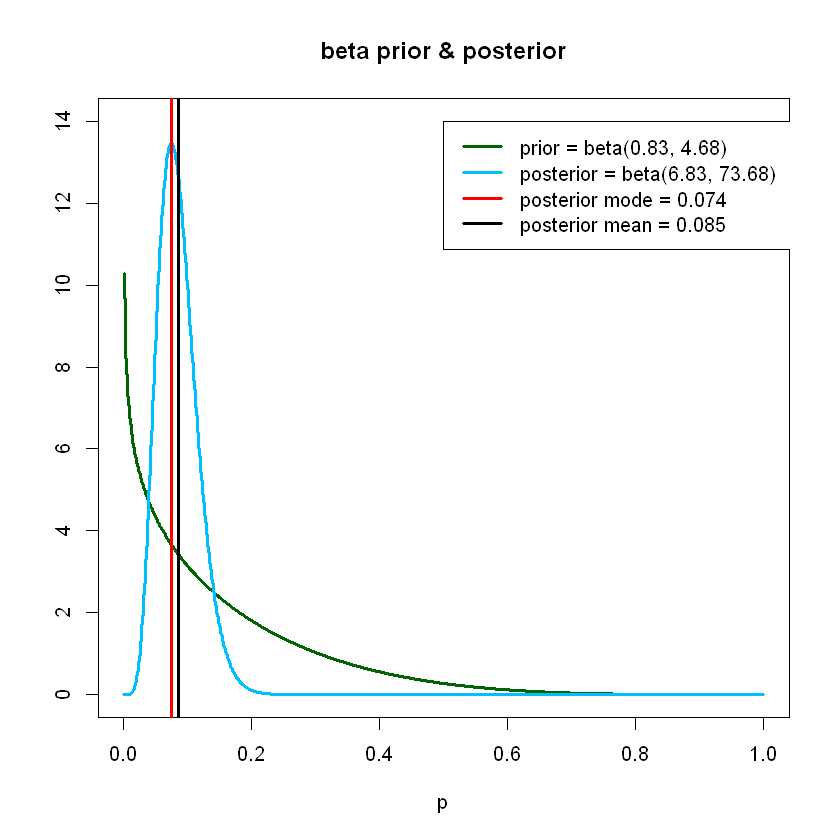

In [6]:
prior <- function(p) dbeta(x = p, shape1 = alpha.prior, shape2 = beta.prior)
posterior <- function(p) dbeta(x = p, shape1 = alpha.posterior, shape2 = beta.posterior)
mode.posterior <- p.vector[which.max(posterior(p.vector))]
print(sprintf("most probable value for p (MAP estimator i.e. posterior mode) = %.3f", mode.posterior))

# we can compute mean and variance exactly using the formulae of the beta distribution
mean.posterior <- alpha.posterior/(alpha.posterior + beta.posterior)
var.posterior  <- alpha.posterior*beta.posterior/((alpha.posterior + beta.posterior)^2*(alpha.posterior + beta.posterior + 1))
print(sprintf("posterior mean = %.3f, posterior var = %.3f", mean.posterior, var.posterior))

plot(p.vector, prior(p.vector), type = "l", lwd = 3, col = "darkgreen", ylim = c(0, 14), main = "beta prior & posterior", xlab = "p", ylab = "")
lines(p.vector, posterior(p.vector), lwd = 3, col = "deepskyblue")
abline(v = mode.posterior, col = "red", lwd = 2.5)
abline(v = mean.posterior, col = "black", lwd = 2.5)

legend(x = 0.5, y = 14, legend = c(sprintf("prior = beta(%.2f, %.2f)", alpha.prior, beta.prior), sprintf("posterior = beta(%.2f, %.2f)", alpha.posterior, beta.posterior), sprintf("posterior mode = %.3f", mode.posterior), sprintf("posterior mean = %.3f", mean.posterior)), lty = rep(1, times = 4), lwd = c(3, 3, 2.5, 2.5), col = c("darkgreen", "deepskyblue", "red", "black"))

### 1.4: Bayesian hypothesis testing
To perform an hypothesis testing in the bayesian way we first need to define a null hypothesis to test; in our case we set:
- Null hypothesis $H_0$: $p \geq p_0$, where $p$ and $p_0$ are the failure probabilities of the new and old tests respectively. If $H_0$ is accepted then the new test isn't better than the old one.
- Alternative hypothesis $H_1$: $p < p_0$, i.e. the new test is better than the old one. 

In a bayesian setting we can easily compute the probability that $p\geq p_0$ using the integral of the posterior; in order to prove/disprove the null hypothesis to a given significance $\alpha$, then, it suffices to compare $\alpha$ with
\begin{equation}
  P(H_0: p\geq p_0) = \int_{p_0}^1 P(p | y) \ \mathrm{d}p
\end{equation}
where $P(p | y) = P(\text{model} | \text{data})$ is the beta posterior computed above.

In [7]:
# we set alpha = 5%
significance <- 0.05 # I use this variable name to avoid confusion with the alpha par. of the beta dist.
p0 <- 0.15 # see problem text for the values of p_0 and of the significance

prob.hyp.testing <- integrate(posterior, p0, 1)$value
print(paste("P(p >= p_0) =", prob.hyp.testing))
test <- prob.hyp.testing >= significance

if (test) {
    print(sprintf("since %.3f is greater than or equal to %.3f we accept the null hypothesis", prob.hyp.testing, significance))
    } else {
        print(sprintf("since %.3f is less than %.3f we reject the null hypothesis", prob.hyp.testing, significance))
}
    

[1] "P(p >= p_0) = 0.0312793302979552"
[1] "since 0.031 is less than 0.050 we reject the null hypothesis"


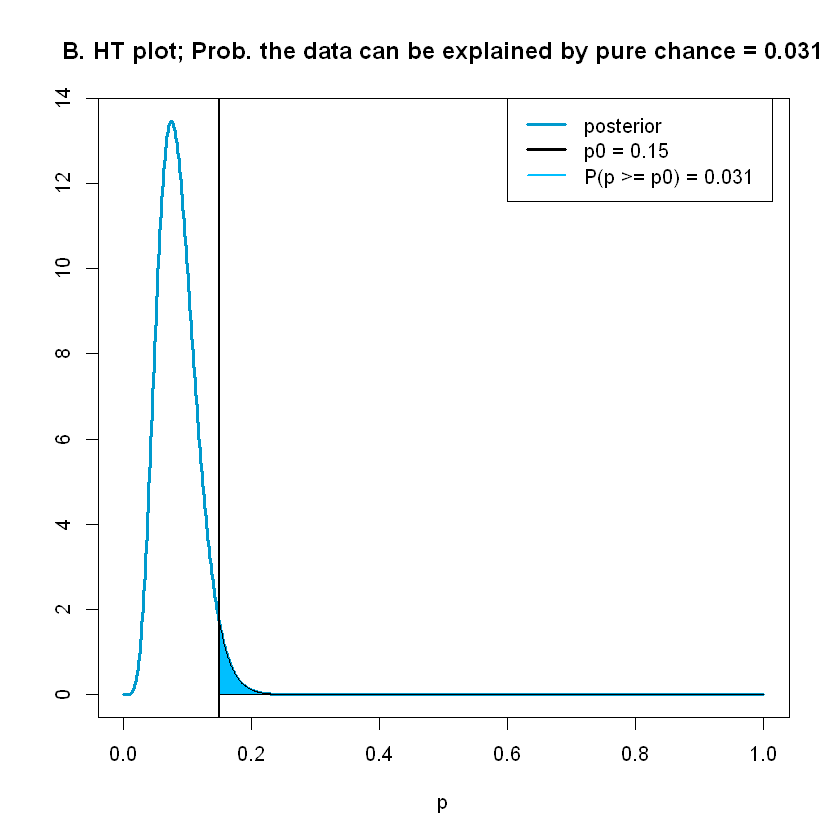

In [8]:
plot(p.vector, posterior(p.vector), type = "l", col = "deepskyblue3", lwd = 3, xlab = "p", ylab = "", main = sprintf("B. HT plot; Prob. the data can be explained by pure chance = %.3f", prob.hyp.testing))
abline(v = p0, col = "black", lwd = 2)
polygon(x = c(p0, p0, p.vector[p.vector >= p0]), y = c(0, posterior(p0), posterior(p.vector[p.vector >= p0])), col = "deepskyblue")

legend(x = 0.6, y = 14, legend = c("posterior", sprintf("p0 = %.2f", p0), sprintf("P(p >= p0) = %.3f", prob.hyp.testing)), lty = rep(1, times = 3), lwd = c(3, 3, 2), col = c("deepskyblue3", "black", "deepskyblue"))

### 1.5 frequentist hypothesis testing
Once again we compare a certain probability with the chosen significance, but this time we rely on the likelihood rather than on the posterior. In the frequentist setting in this case the null hypothesis $H_0$ is "the data is generated by the binomial likelihood with $p=p_0$"; if this likelihood predicts that the probability of observing the data we actually observed/something more extreme ($y/n \leq 6/75$) is smaller than the significance then $H_0$ is rejected.       
To recap: we reject the null hypothesis (i.e. the new test is better to the chosen significance level) if
\begin{equation}
  \text{p-value} = P_{\text{binom}}(y \leq 6 | p = p_0 = 0.15, N = n = 75) = \sum_{i = 0}^6 P_{\text{binom}}(i | p = p_0, N = n) < \alpha
\end{equation}
Note: in practice there's no need to actually perform the sum of `dbinom` since `pbinom` takes care of this for us.

In [9]:
p.value <- pbinom(6, size = n, prob = p0)
# p.value <- sum(dbinom(0:6, size = n, prob = p0)) # if we want to be explicit
print(paste("p value =", p.value))

if (p.value < significance) {
    print(sprintf("since %f is less than %f we reject the null hypothesis", p.value, significance))
} else {
    print(sprintf("since %f is greater than or equal to %f we accept the null hypothesis", p.value, significance))
}

[1] "p value = 0.0543533033542315"
[1] "since 0.054353 is greater than or equal to 0.050000 we accept the null hypothesis"


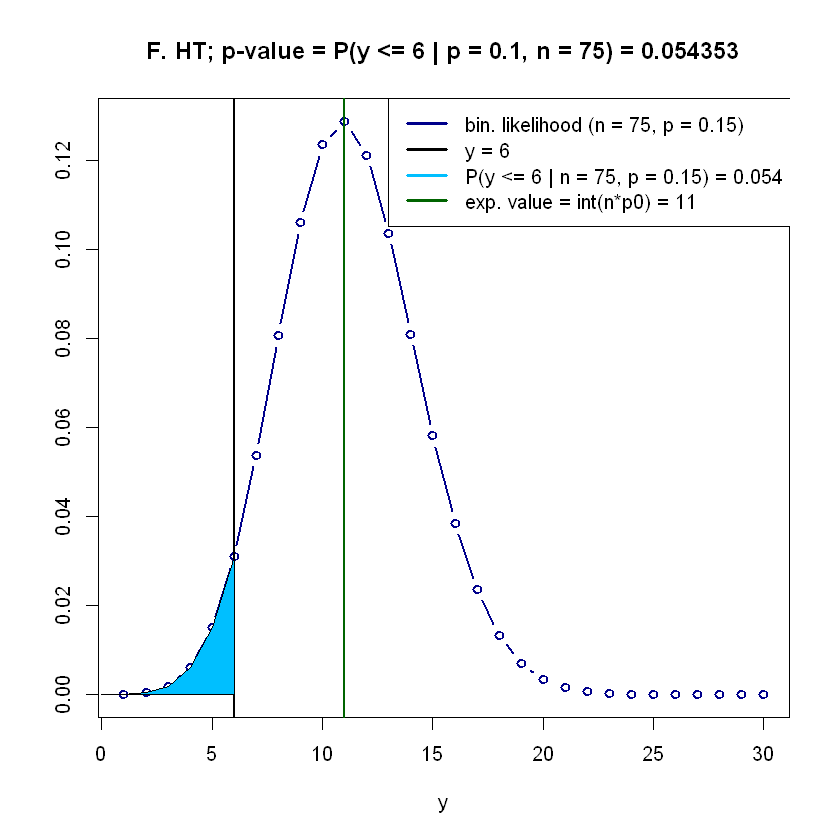

In [10]:
y.vector <- 1:30 # y can only have integer values
fht.vector <- dbinom(y.vector, size = n, prob = p0)

plot(y.vector, fht.vector, type = "b", col = "darkblue", lwd = 2, xlab = "y", ylab = "", main = sprintf("F. HT; p-value = P(y <= %i | p = %.1f, n = %i) = %f", y, p0, n, p.value))
abline(v = y, col = "black", lwd = 2)
polygon(x = c(0, y.vector[y.vector <= y], y), y = c(0, fht.vector[y.vector <= y], 0), col = "deepskyblue")

exp.value <- round(n*p0)
abline(v = exp.value, col = "darkgreen", lwd = 2)

legend(x = 13, y = 0.134, legend = c(sprintf("bin. likelihood (n = %i, p = %.2f)", n, p0), sprintf("y = %i", y), sprintf("P(y <= %i | n = %i, p = %.2f) = %.3f", y, n, p0, p.value), sprintf("exp. value = int(n*p0) = %d", exp.value)), lty = rep(1, times = 4), col = c("darkblue", "black", "deepskyblue", "darkgreen"), lwd = rep(2.5, times = 4))

## Ex.2: Poisson distribution
Before starting with the actual solution let us do a brief remark.               
Given $n$ independent samples $\{ y_i \}$ the Poisson likelihood is:
\begin{equation}
  P(\{y_i\} | \mu) = \prod_{i=1}^n \frac{\mu^{y_i} e^{-\mu} }{y_i!} \propto \mu^{\sum_{i=1}^n y_i} \cdot e^{-n\mu}
\end{equation}
This actually equals a Gamma distribution up to a constant! This is true because by definition
\begin{equation}
  \text{Gamma}(x | \alpha, \lambda) \propto x^{\alpha - 1} e^{-\lambda x}
\end{equation}
hence if we set $\alpha = \sum_{i=1}^n y_i + 1$, $\lambda = n$ and $x = \mu$ then the two pdfs are identical.          
This is useful because it lets us recycle the following analytical formulae for the gamma distribution:
\begin{equation}
  \text{mean} = \frac{\alpha}{\lambda}
\end{equation}
\begin{equation}
  \text{mode} = \frac{\alpha - 1}{\lambda}
\end{equation}
\begin{equation}
  \text{var} = \frac{\alpha}{\lambda^2}
\end{equation}

### 2.1: posterior given a uniform prior
To solve this exercise we need to perform a standard inference: we apply Bayes theorem to compute the posterior, then compute various interesting quantities from the obtained distribution.        
If we assume a uniform prior then the posterior equals the likelihood up to a constant, which means it suffices to normalize the Poisson likelihood to obtain the result.

In [11]:
# first let's import the data 
y1 <- c(109, 65, 22, 3, 1)
y2 <- c(144, 91, 32, 11, 2)
n.deaths <- 0:4

deaths.df <- data.frame(y = n.deaths, n1 = y1, n2 = y2)
deaths.df

y,n1,n2
<int>,<dbl>,<dbl>
0,109,144
1,65,91
2,22,32
3,3,11
4,1,2


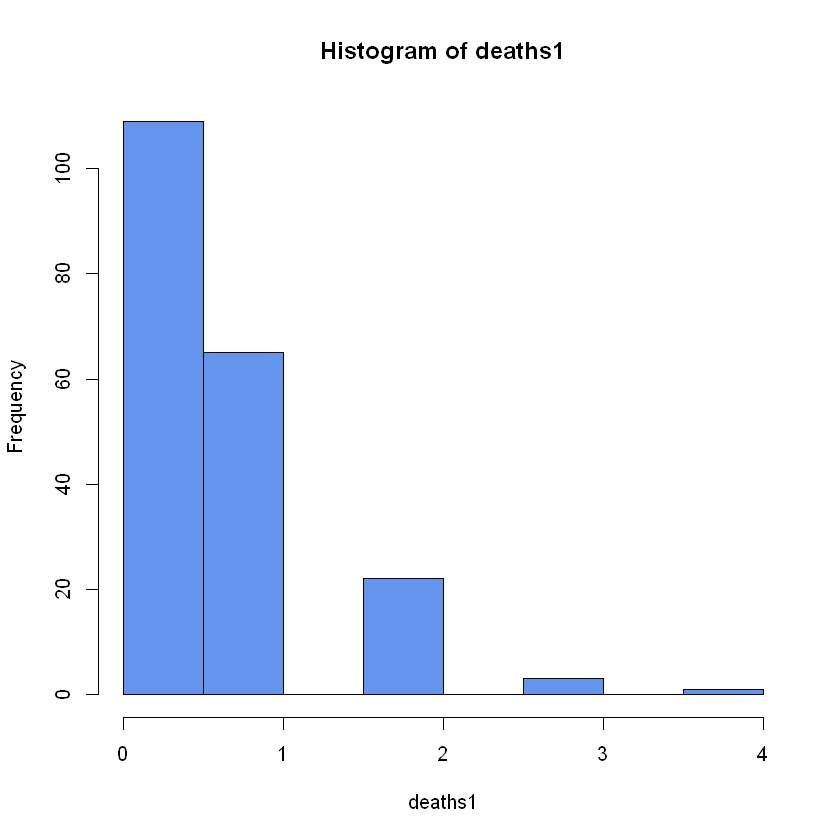

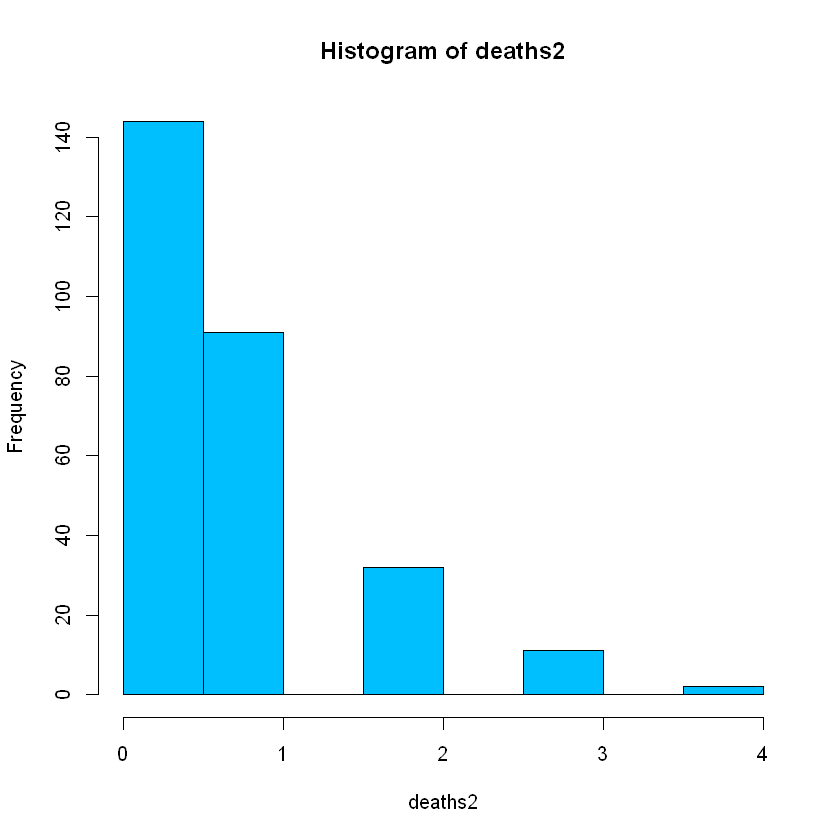

In [12]:
# we can visualize the above dataframe using an histogram. To do so we use append to progressively assemble
# a vector containing each value of the n column repeated n1/n2 times

deaths1 <- NULL; deaths2 <- NULL # equivalent to using c()

for (i in 1:5) {
    deaths1 <- append(deaths1, values = rep(n.deaths[i], times = y1[i]))
    deaths2 <- append(deaths2, values = rep(n.deaths[i], times = y2[i]))
}

hist(deaths1, col = "cornflowerblue")
hist(deaths2, col = "deepskyblue")

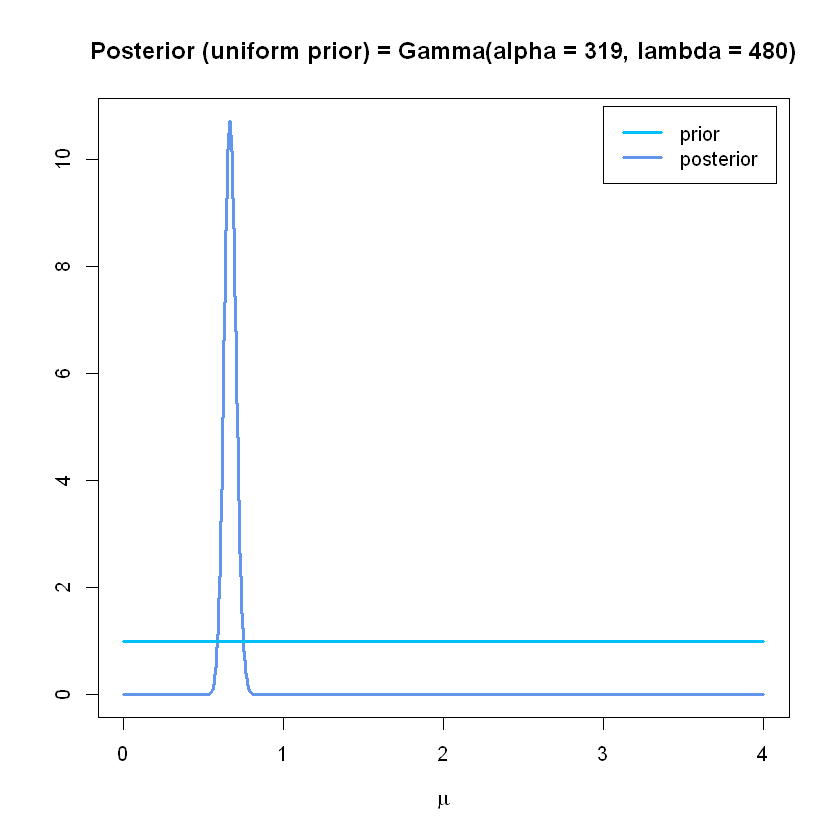

In [13]:
# we already proved some homeworks ago that if two datasets related to the same experiment are collected 
# indepentently in different times then we can consider them as a single dataset and perform a single 
# "collective" inference; even ignoring this result we can easily show that (inf. wrt n1) + (inf. wrt n2) = (inf. wrt n1+n2)
# Indeed if we multiply two gamma dist. the resulting function will be another gamma dist. with parameters
# equal to the sum of the parameters of the previous gammas

# POSTERIOR COMPUTATION:
alpha.uniform <- sum(deaths1) + sum(deaths2) + 1
lambda.uniform <- length(deaths1) + length(deaths2)

posterior.uniform.prior <- function(mu) dgamma(x = mu, shape = alpha.uniform, rate = lambda.uniform)

mu.vector <- seq(0, 4, length.out = 1000)
plot(mu.vector, posterior.uniform.prior(mu.vector), type = "l", col = "cornflowerblue", lwd = 3, main = sprintf("Posterior (uniform prior) = Gamma(alpha = %i, lambda = %i)", alpha.uniform, lambda.uniform), xlab = expression(mu), ylab = "")
lines(mu.vector, rep(1, times = length(mu.vector)), lwd = 3, col = "deepskyblue")
legend(x = 3, y = 11, legend = c("prior", "posterior"), lty = rep(1, 2), lwd = rep(3, 2), col = c("deepskyblue", "cornflowerblue"))

In [14]:
# if we have the gamma distribution's alpha and lambda parameters we can easily compute the mode,
# mean and variance using the aforementioned formulae

compute.gamma.quantities <- function(alpha, lambda) {
    mean <-  alpha/lambda
    mode <- (alpha - 1)/lambda
    var  <-  alpha/lambda^2
    return (list(mean = mean, mode = mode, var = var))
}

print(sprintf("The posterior obtained from a uniform prior is a Gamma(%i, %i) distribution with:", alpha.uniform, lambda.uniform))
l.uniform.prior <- compute.gamma.quantities(alpha.uniform, lambda.uniform)
l.uniform.prior

[1] "The posterior obtained from a uniform prior is a Gamma(319, 480) distribution with:"


$mean
[1] 0.6645833

$mode
[1] 0.6625

$var
[1] 0.001384549

[1] "area under the posterior between 0.590 and 0.739 = 0.955"


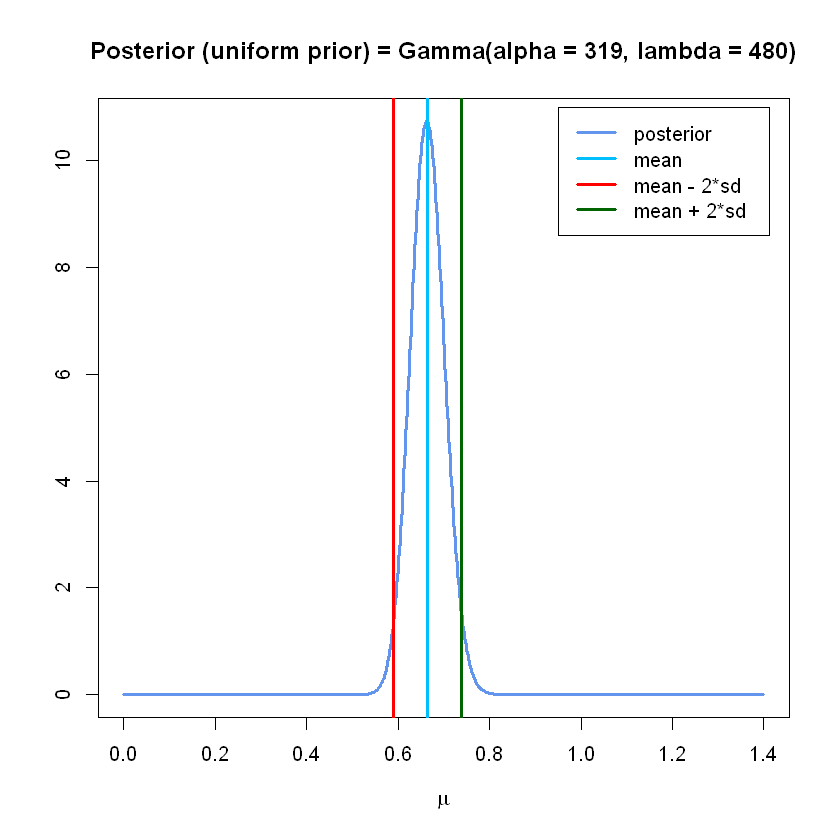

In [15]:
# finally to compute the 95% credibility integral we can approximate our posterior to a gaussian with the
# same mean and variance, then exploit the fact that 95% of the area under a gaussian is contained between
# mean +- 2*sd

m.u <- l.uniform.prior$mean; s.u <- sqrt(l.uniform.prior$var)
a.u <- m.u - 2*s.u; b.u <- m.u + 2*s.u
area.u <- integrate(posterior.uniform.prior, a.u, b.u)$value
print(sprintf("area under the posterior between %.3f and %.3f = %.3f", a.u, b.u, area.u))

x <- seq(0, 1.4, length.out = 1000)
plot(x, posterior.uniform.prior(x), type = "l", col = "cornflowerblue", lwd = 3, main = sprintf("Posterior (uniform prior) = Gamma(alpha = %i, lambda = %i)", alpha.uniform, lambda.uniform), xlab = expression(mu), ylab = "")
abline(v = m.u, col = "deepskyblue", lwd = 3)
abline(v = a.u, col = "red", lwd = 3)
abline(v = b.u, col = "darkgreen", lwd = 3)
legend(x = 0.95, y = 11, legend = c("posterior", "mean", "mean - 2*sd", "mean + 2*sd"), lty = rep(1, 4), lwd = rep(3, 4), col = c("cornflowerblue", "deepskyblue", "red", "darkgreen"))

### Jeffrey's prior
This time the prior is $g(\mu) \propto \mu^{-1/2}$; when we multiply this by the Poisson likelihood we obtain the following posterior:
\begin{equation}
  P(\mu | \{y_i\}) \propto \mu^{\left(\sum_{i=1}^n y_i\right)-1/2} \cdot e^{-n\mu}
\end{equation}
Once again we notice this is none other than a gamma distribution with $\alpha = \sum_{i=1}^n y_i + 1/2$ and $\lambda = n$, so we can easily recycle the above code.

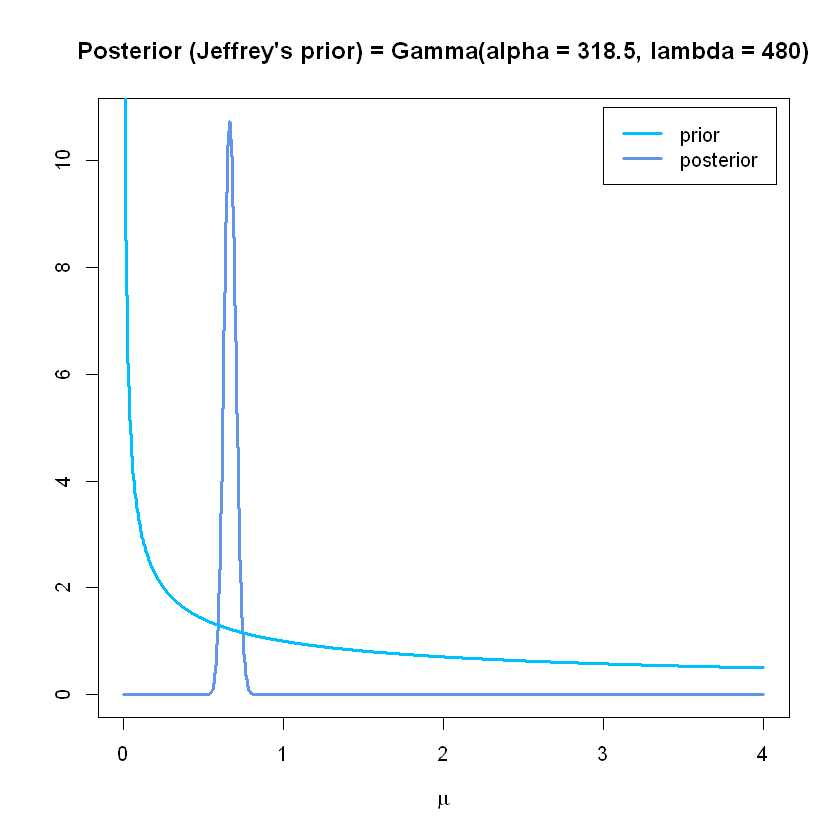

In [16]:
alpha.jeffrey <- sum(deaths1) + sum(deaths2) + 1/2
lambda.jeffrey <- length(deaths1) + length(deaths2)

posterior.jeffrey.prior <- function(mu) dgamma(x = mu, shape = alpha.jeffrey, rate = lambda.jeffrey)

mu.vector <- seq(0, 4, length.out = 1000)
plot(mu.vector, posterior.jeffrey.prior(mu.vector), type = "l", col = "cornflowerblue", lwd = 3, main = sprintf("Posterior (Jeffrey's prior) = Gamma(alpha = %.1f, lambda = %i)", alpha.jeffrey, lambda.jeffrey), xlab = expression(mu), ylab = "")
lines(mu.vector, 1/sqrt(mu.vector), lwd = 3, col = "deepskyblue")
legend(x = 3, y = 11, legend = c("prior", "posterior"), lty = rep(1, 2), lwd = rep(3, 2), col = c("deepskyblue", "cornflowerblue"))

In [17]:
print(sprintf("The posterior obtained from Jeffrey's prior is a Gamma(%.1f, %i) distribution with:", alpha.jeffrey, lambda.jeffrey))
l.jeffrey.prior <- compute.gamma.quantities(alpha.jeffrey, lambda.jeffrey)
l.jeffrey.prior

[1] "The posterior obtained from Jeffrey's prior is a Gamma(318.5, 480) distribution with:"


$mean
[1] 0.6635417

$mode
[1] 0.6614583

$var
[1] 0.001382378

[1] "area under the posterior between 0.589 and 0.738 = 0.955"


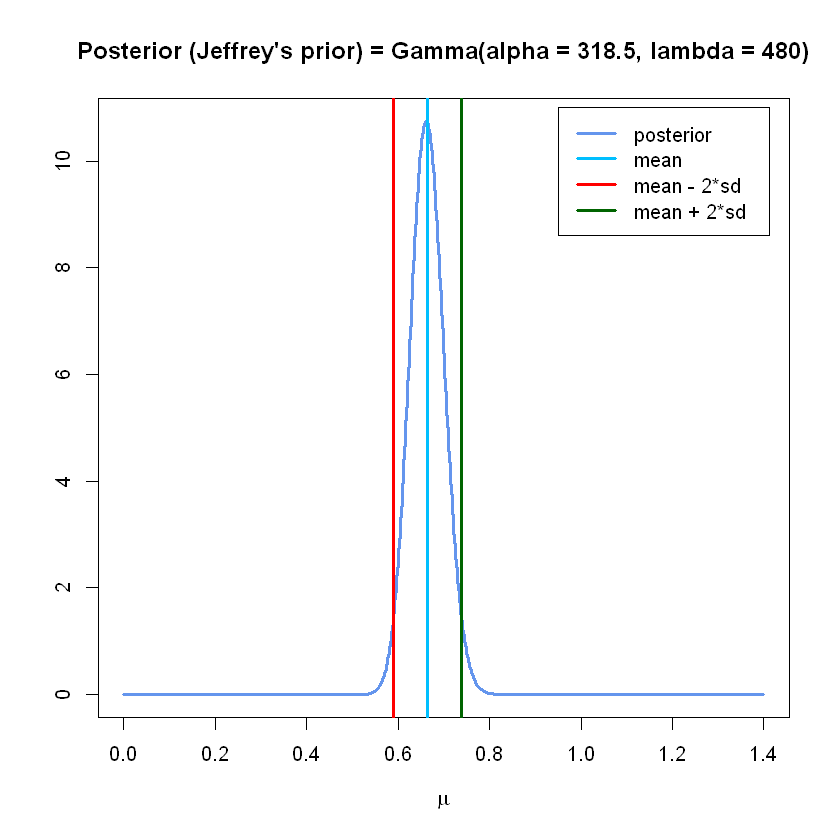

In [18]:
m.j <- l.jeffrey.prior$mean; s.j <- sqrt(l.jeffrey.prior$var)
a.j <- m.j - 2*s.j; b.j <- m.j + 2*s.j
area.j <- integrate(posterior.jeffrey.prior, a.j, b.j)$value
print(sprintf("area under the posterior between %.3f and %.3f = %.3f", a.j, b.j, area.j))

x <- seq(0, 1.4, length.out = 1000)
plot(x, posterior.jeffrey.prior(x), type = "l", col = "cornflowerblue", lwd = 3, main = sprintf("Posterior (Jeffrey's prior) = Gamma(alpha = %.1f, lambda = %i)", alpha.jeffrey, lambda.jeffrey), xlab = expression(mu), ylab = "")
abline(v = m.j, col = "deepskyblue", lwd = 3)
abline(v = a.j, col = "red", lwd = 3)
abline(v = b.j, col = "darkgreen", lwd = 3)
legend(x = 0.95, y = 11, legend = c("posterior", "mean", "mean - 2*sd", "mean + 2*sd"), lty = rep(1, 4), lwd = rep(3, 4), col = c("cornflowerblue", "deepskyblue", "red", "darkgreen"))

## Ex. 3: water quality
Similarly to the first exercise we can assume that $y$ (the number of observed bacteria in a sample) is a random variable sampled from a binomial distribution parametrized by a certain $p$; $p$ is unknown but fixed in the frequentist approach, and a random variable distributed according to a certain posterior in the bayesian one.
### 3.1: frequentist estimator for $p$
Exactly like in ex. 1 an unbiased estimator for the bias of a binomial likelihood is the ratio of observed successes/n. of samples, i.e. $y/n$.

In [19]:
y  <- 11; n <- 116 # cfr problem text
pf <- y/n
print(paste("frequentist estimator for p:", pf))

[1] "frequentist estimator for p: 0.0948275862068965"


### 3.2 & 3.3: Bayesian inference of $p$
As in ex. 1 to tackle this problem from a bayesian point of view we need to compute the posterior, which is easily done if we choose a beta prior (since this family of distribution is conjugate to the binomial likelihood, as already mentioned); using the simple update rules we obtain that the posterior is a beta distribution with $\alpha' = \alpha + y$, $\beta' = \beta + n - y$.

In [20]:
alpha.prior <- 1; beta.prior <- 10
alpha.posterior <- alpha.prior + y; beta.posterior <- beta.prior + n - y

print(paste("prior alpha, beta parameters = ", alpha.prior, "and", beta.prior))
print(paste("posterior alpha, beta parameters = ", alpha.posterior, "and", beta.posterior))

[1] "prior alpha, beta parameters =  1 and 10"
[1] "posterior alpha, beta parameters =  12 and 115"


[1] "most probable value for p (MAP estimator i.e. posterior mode) = 0.088"
[1] "posterior mean = 0.094, posterior var = 0.001"


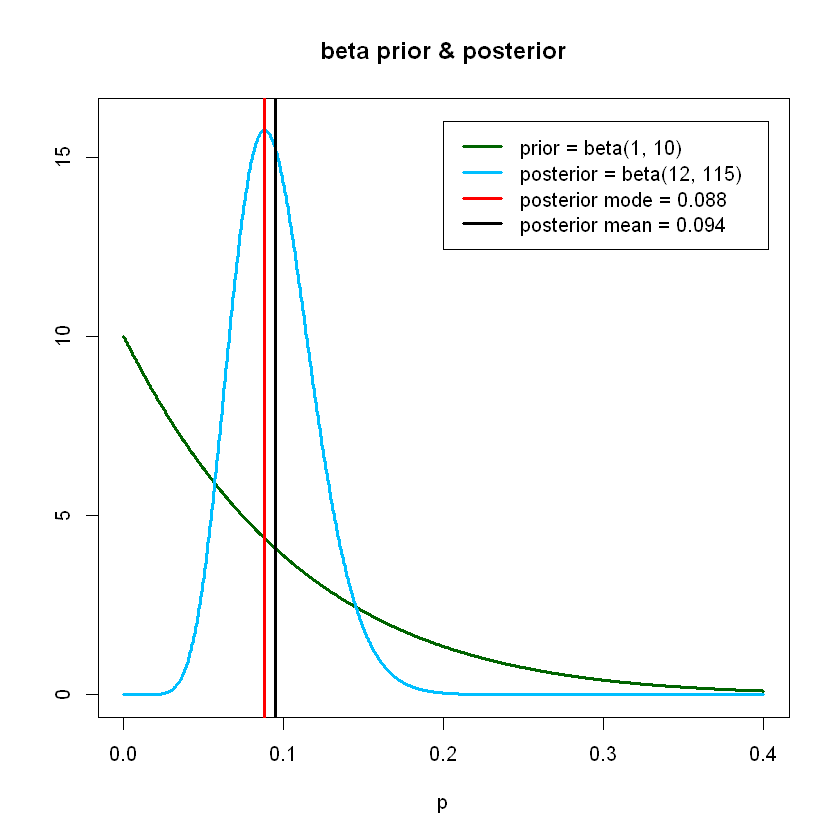

In [21]:
prior <- function(p) dbeta(x = p, shape1 = alpha.prior, shape2 = beta.prior)
posterior <- function(p) dbeta(x = p, shape1 = alpha.posterior, shape2 = beta.posterior)
mode.posterior <- (alpha.posterior - 1)/(alpha.posterior + beta.posterior -2) # this time we use the analytical formula instead of a numerical estimation using which.max
print(sprintf("most probable value for p (MAP estimator i.e. posterior mode) = %.3f", mode.posterior))

# we can compute mean and variance exactly using the formulae of the beta distribution
mean.posterior <- alpha.posterior/(alpha.posterior + beta.posterior)
var.posterior  <- alpha.posterior*beta.posterior/((alpha.posterior + beta.posterior)^2*(alpha.posterior + beta.posterior + 1))
print(sprintf("posterior mean = %.3f, posterior var = %.3f", mean.posterior, var.posterior))

p.vector <- seq(0, 0.4, length.out = 1000) # in theory this should be seq(0, 1, ...), but since for p > 0.5 everything is basically 0 I'm cutting that part out so one can see more clearly. cfr ex. 1
plot(p.vector, prior(p.vector), type = "l", lwd = 3, col = "darkgreen", ylim = c(0, 16), main = "beta prior & posterior", xlab = "p", ylab = "")
lines(p.vector, posterior(p.vector), lwd = 3, col = "deepskyblue")
abline(v = mode.posterior, col = "red", lwd = 2.5)
abline(v = mean.posterior, col = "black", lwd = 2.5)

# use x = 0.5 if p.vector is seq(0, 1, ...)
legend(x = 0.2, y = 16, legend = c(sprintf("prior = beta(%i, %i)", alpha.prior, beta.prior), sprintf("posterior = beta(%i, %i)", alpha.posterior, beta.posterior), sprintf("posterior mode = %.3f", mode.posterior), sprintf("posterior mean = %.3f", mean.posterior)), lty = rep(1, times = 4), lwd = c(3, 3, 2.5, 2.5), col = c("darkgreen", "deepskyblue", "red", "black"))

In [22]:
print(paste("the ratio between the frequentist estimator and the posterior mean is", pf/mean.posterior))
print("this means the frequentist and bayesian estimators are basically identical")

[1] "the ratio between the frequentist estimator and the posterior mean is 1.00359195402299"
[1] "this means the frequentist and bayesian estimators are basically identical"


[1] "area under the posterior between 0.043 and 0.146 = 0.958"


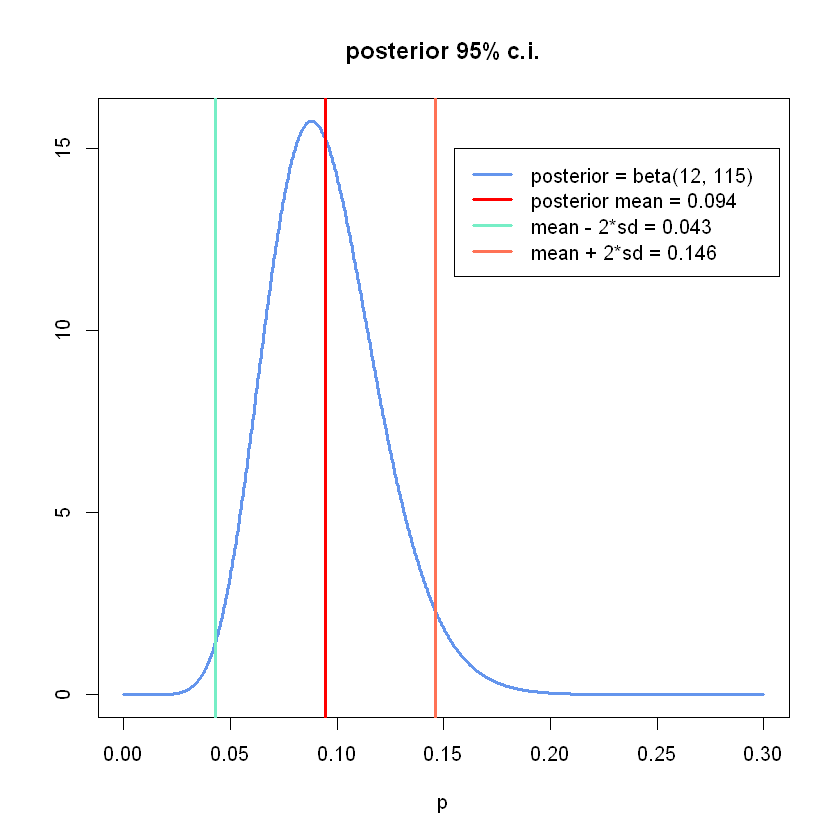

In [23]:
# credibility interval: once again we can exploit a 2 sigma gaussian approximation

m <- mean.posterior; s <- sqrt(var.posterior)
a <- m - 2*s; b <- m + 2*s

area <- integrate(posterior, a, b)$value
print(sprintf("area under the posterior between %.3f and %.3f = %.3f", a, b, area))

x <- seq(0, 0.3, length.out = 1000)
plot(x, posterior(x), type = "l", col = "cornflowerblue", lwd = 3, main = "posterior 95% c.i.", xlab = "p", ylab = "")
abline(v = m, col = "red", lwd = 2.5)
abline(v = m - 2*s, col = "aquamarine2", lwd = 2.5)
abline(v = m + 2*s, col = "coral1", lwd = 2.5)

legend(x = 0.155, y = 15, legend = c(sprintf("posterior = beta(%i, %i)", alpha.posterior, beta.posterior), sprintf("posterior mean = %.3f", mean.posterior), sprintf("mean - 2*sd = %.3f", m - 2*s), sprintf("mean + 2*sd = %.3f", m + 2*s)), lty = rep(1, 4), lwd = c(3, 2.5, 2.5, 2.5), col = c("cornflowerblue", "red", "aquamarine2", "coral1"))

### 3.4: frequentist vs bayesian hypothesis testing with $\alpha = 5\%$
In both cases we need to accept/reject the null hypothesis $H_0: p = 0.1$.            
*Bayesian approach*: we already computed the $95\% = 1-\alpha$ area under the posterior, which corresponds to the interval $[0.043, 0.146]$; this is the acceptance region, where with probability $1-\alpha$ we can be confident $p$ resides. If $p_0=0.1$ was outside this interval we could conclude that $P(H_0|y)\leq 5\%$, but since this is not the case we accept the null hypothesis.               
*Frequentist approach*: we assume $H_0$ holds and by consequence that the data we observed was generated by a binomial likelihood with $p=0.1$; we then look for two *integer* values $k_1$ and $k_2$ such that the probability of observing $k$ outside the interval $[k_1, k_2]$ is as close as possible to $\alpha = 5\%$. The idea is that if our observed $k=y$ is outside the acceptance region then it means that it's too unlikely to observe the data we actually observed with this value of $p$, and therefore that $H_0$ is to be rejected. With some trial and error we find that with $k_1 = 6$ and $k_2 = 20$ the interval $[k_1, k_2]$ contains our observed $k=y=11$ and is such that the probability of observing a $k$ *outside* this range is $0.0538$ - which is *greater* than $\alpha = 0.05$! This means that $p=0.1$ can still explain the data to the chosen confidence level; this value for the binomial bias isn't "wrong" enough to make the data we observed as unlikely as is needed to convince us to reject the null hypothesis, hence even in the frequentist setting we accept $H_0$.

[1] "since 0.1 is inside [0.043, 0.146] we accept the null hypothesis"


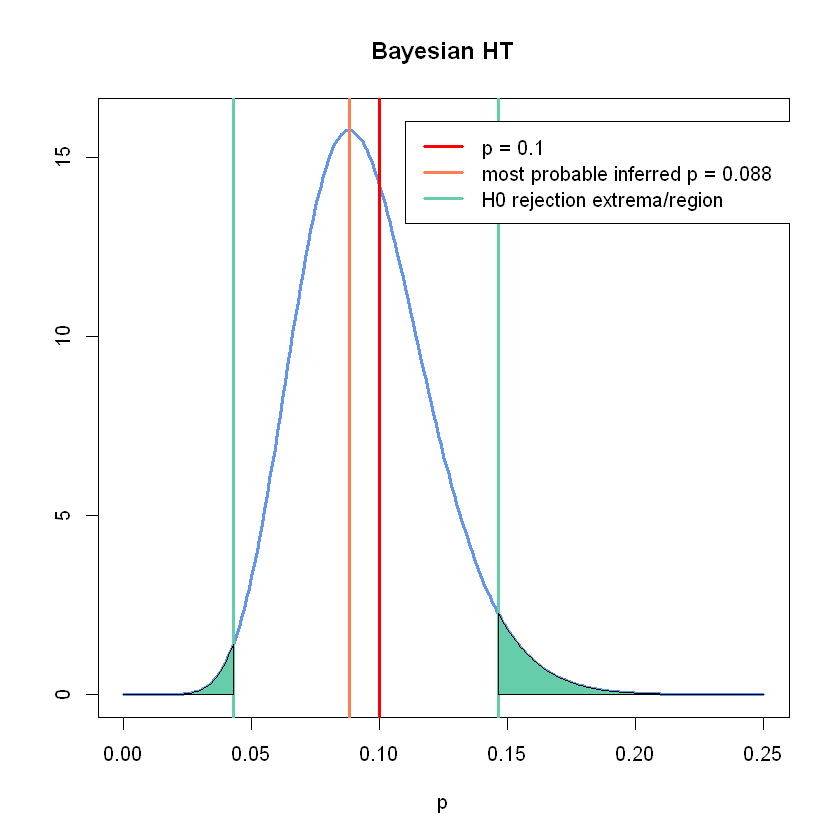

In [24]:
# Bayesian H.T.

p0 <- 0.1 # the value of p if H0 holds

if ((p0 <= a) | (b <= p0)) {
    print(sprintf("since %.1f is outside [%.3f, %.3f] we reject the null hypothesis", p0, a, b))
} else {
    print(sprintf("since %.1f is inside [%.3f, %.3f] we accept the null hypothesis", p0, a, b))
}

p.vector <- seq(0, 0.25, 0.001)
plot(p.vector, posterior(p.vector), type = "l", lwd = 3, col = "cornflowerblue", ylim = c(0, 16), main = "Bayesian HT", xlab = "p", ylab = "")
abline(v = 0.1, lwd = 2.5, col = "red")
abline(v = mode.posterior, lwd = 2.5, col = "coral")
abline(v = a, col = "aquamarine3", lwd = 2.5)
abline(v = b, col = "aquamarine3", lwd = 2.5)

polygon(x = c(0, p.vector[p.vector <= a], a, a), y = c(0, posterior(p.vector[p.vector <= a]), posterior(a), 0), col = "aquamarine3")
polygon(x = c(b, b, p.vector[p.vector >= b], 0.25), y = c(0, posterior(b), posterior(p.vector[p.vector >= b]), 0), col = "aquamarine3")

legend(x = 0.11, y = 16, legend = c("p = 0.1", sprintf("most probable inferred p = %.3f", mode.posterior), "H0 rejection extrema/region"), lty = rep(1, 3), lwd = rep(3, 3), col = c("red", "coral", "aquamarine3"))

In [25]:
# Frequentist H.T.

k1 <- 6; k2 <- 20
prob = pbinom(k2, size = n, prob = p0) - pbinom(k1, size = n, prob = p0) # P(k1 <= k <= k2) = P(k <= k2) - P(k <= k1)
p.value = 1 - prob # p-value = the probability that the observed k = y lies outside the acceptance region if H0 holds
# i.e. if the data comes from Binom(p = 0.1)

print(sprintf("probability of observing y < %i or > %i with p = %.1f, n = %i: %.4f", k1, k2, p0, n, p.value))

significance <- 0.05
if (p.value < significance) {
    print(sprintf("since %.4f is less than %.2f we reject the null hypothesis", p.value, significance))
} else {
    print(sprintf("since %.4f is greater than or equal to %.2f we accept the null hypothesis", p.value, significance))
}

[1] "probability of observing y < 6 or > 20 with p = 0.1, n = 116: 0.0538"
[1] "since 0.0538 is greater than or equal to 0.05 we accept the null hypothesis"


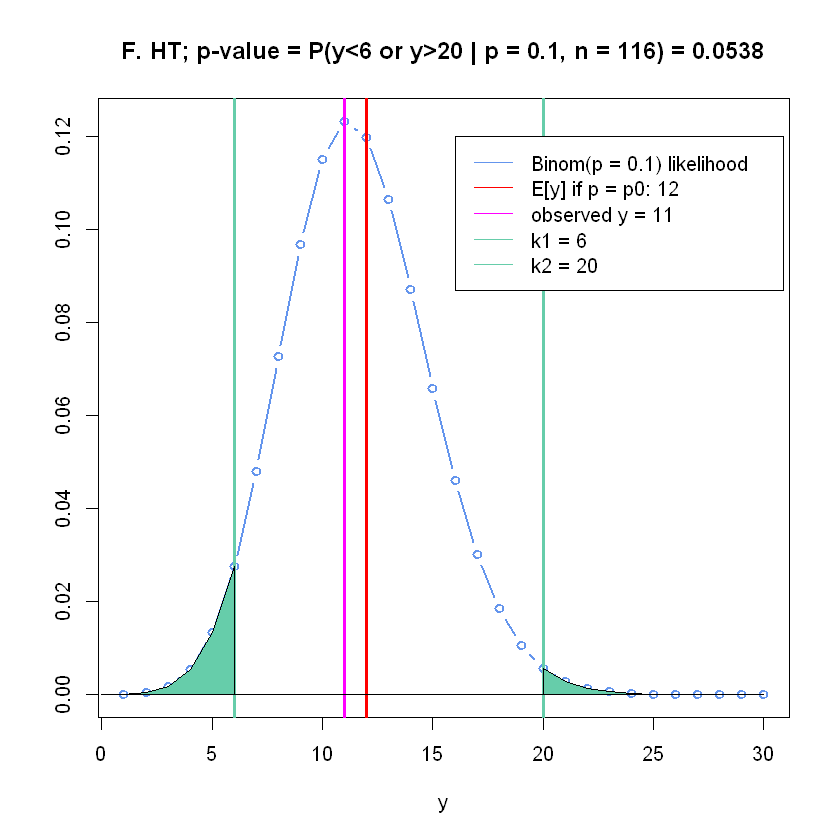

In [26]:
# this time we need to plot the likelihood, which means we need to plot y (not p) on the x-axis
y.vector <- 1:30 # y can only take on integer values
fht.vector <- dbinom(y.vector, size = n, prob = p0)

plot(y.vector, fht.vector, type = "b", col = "cornflowerblue", lwd = 2, xlab = "y", ylab = "", main = sprintf("F. HT; p-value = P(y<%i or y>%i | p = %.1f, n = %i) = %.4f", k1, k2, p0, n, p.value))

abline(v = k1, col = "aquamarine3", lwd = 2.5); abline(v = k2, col = "aquamarine3", lwd = 2.5)
abline(v = y, col = "magenta", lwd = 2.5)

exp.val <- round(p0*n)
abline(v = exp.val, col = "red", lwd = 2.5)

polygon(x = c(0, y.vector[y.vector <= k1], k1), y = c(0, fht.vector[y.vector <= k1], 0), col = "aquamarine3")
polygon(x = c(k2, y.vector[y.vector >= k2], 0), y = c(0, fht.vector[y.vector >= k2], 0), col = "aquamarine3")

legend(x = 16, y = 0.12, legend = c(sprintf("Binom(p = %.1f) likelihood", p0), sprintf("E[y] if p = p0: %i", exp.val), sprintf("observed y = %i", y), sprintf("k1 = %i", k1), sprintf("k2 = %i", k2)), lty = rep(1, 5), col = c("cornflowerblue", "red", "magenta", rep("aquamarine3", 2)))

To recap: in the bayesian approach we do a standard inference of $p$ and compute in which interval we can be $(1-\alpha) \cdot 100\%$ confident $p$ lies; if $p_0$ is **not** in this interval it means that the probability $H_0$ holds is too low and we have to reject it. Since we found that $p_0$ is **not** outside the most probable interval it means that our data isn't "extreme" enough to force us to discard $H_0$.             
In the frequentist approach we instead ask ourselves: if $H_0$ holds then how likeliy/unlikely is it to observe the data we actually observed? If we find that the probability of observing our data is too low (smaller than $\alpha$) then it means that $H_0$ cannot satisfyingly explain the data, and therefore that $p_0$ is definitely wrong and that we have to reject the null hypothesis. Once again we found that the data isn't "extreme" enough to reject $H_0$.          

These results are hardly surprising: the Bayesian (MAP) estimator for $p$ is $0.088$ i.e. very close to $0.1$, and the same is true for the frequentist (MLE) estimator since we observed $y=11$ - which is almost equal to $E[y] = np_0 = \text{int}(11.6)=12$.
                  
Notice that in both setting we look for some probability distribution and investigate its tails, i.e. the most unlikely regions, and say that if our data-driven estimators lie there then the hypothesis is too unlikely to be true; the difference is whether this distribution is the posterior or the likelihood, i.e. whether we incorporate the prior or not.

### 3.5-3.8: new data
To conclude the exercise we recycle everything with the new values $y' = 9$, $n' = 165$.

### 3.5: frequentist estimator for $p$ (new data)

In [27]:
# frequentist estimator for p
y  <- 9; n <- 165 # cfr problem text
pf <- y/n
print(paste("frequentist estimator for p:", pf))

[1] "frequentist estimator for p: 0.0545454545454545"


### 3.6 & 3.7: Bayesian inference of $p$

In [28]:
alpha.prior <- 1; beta.prior <- 10
alpha.posterior <- alpha.prior + y; beta.posterior <- beta.prior + n - y

print(paste("prior alpha, beta parameters = ", alpha.prior, "and", beta.prior))
print(paste("posterior alpha, beta parameters = ", alpha.posterior, "and", beta.posterior))

[1] "prior alpha, beta parameters =  1 and 10"
[1] "posterior alpha, beta parameters =  10 and 166"


[1] "most probable value for p (MAP estimator i.e. posterior mode) = 0.052"
[1] "posterior mean = 0.057, posterior var = 0.00030"


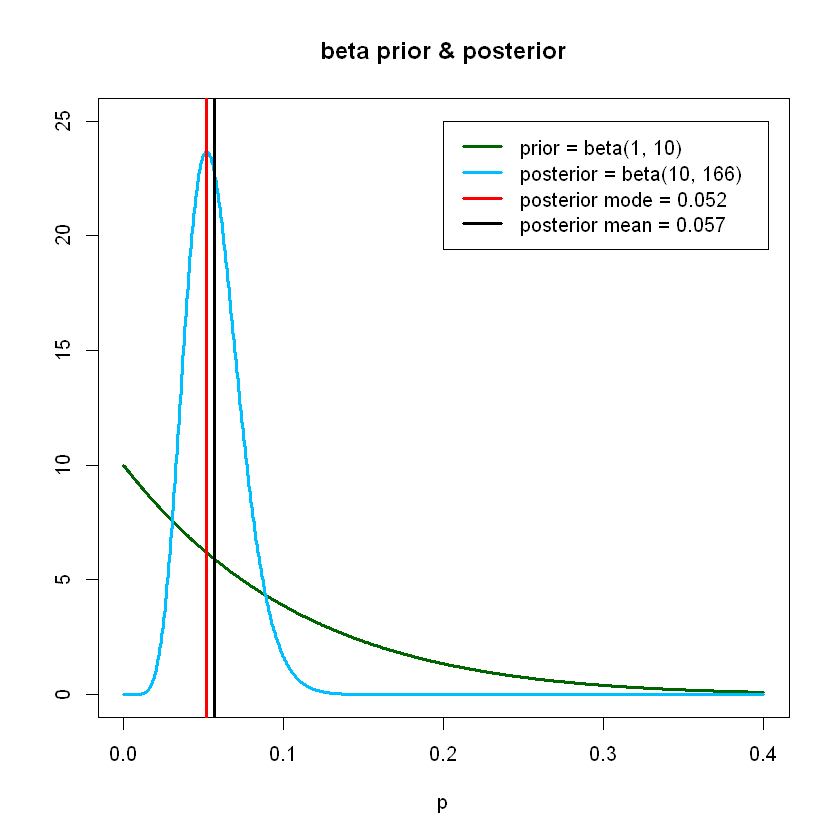

In [29]:
prior <- function(p) dbeta(x = p, shape1 = alpha.prior, shape2 = beta.prior)
posterior <- function(p) dbeta(x = p, shape1 = alpha.posterior, shape2 = beta.posterior)
mode.posterior <- (alpha.posterior - 1)/(alpha.posterior + beta.posterior -2) # this time we use the analytical formula instead of a numerical estimation using which.max
print(sprintf("most probable value for p (MAP estimator i.e. posterior mode) = %.3f", mode.posterior))

# we can compute mean and variance exactly using the formulae of the beta distribution
mean.posterior <- alpha.posterior/(alpha.posterior + beta.posterior)
var.posterior  <- alpha.posterior*beta.posterior/((alpha.posterior + beta.posterior)^2*(alpha.posterior + beta.posterior + 1))
print(sprintf("posterior mean = %.3f, posterior var = %.5f", mean.posterior, var.posterior))

p.vector <- seq(0, 0.4, length.out = 1000) # in theory this should be seq(0, 1, ...), but since for p > 0.5 everything is basically 0 I'm cutting that part out so one can see more clearly. cfr ex. 1
plot(p.vector, prior(p.vector), type = "l", lwd = 3, col = "darkgreen", ylim = c(0, 25), main = "beta prior & posterior", xlab = "p", ylab = "")
lines(p.vector, posterior(p.vector), lwd = 3, col = "deepskyblue")
abline(v = mode.posterior, col = "red", lwd = 2.5)
abline(v = mean.posterior, col = "black", lwd = 2.5)

# use x = 0.5 if p.vector is seq(0, 1, ...)
legend(x = 0.2, y = 25, legend = c(sprintf("prior = beta(%i, %i)", alpha.prior, beta.prior), sprintf("posterior = beta(%i, %i)", alpha.posterior, beta.posterior), sprintf("posterior mode = %.3f", mode.posterior), sprintf("posterior mean = %.3f", mean.posterior)), lty = rep(1, times = 4), lwd = c(3, 3, 2.5, 2.5), col = c("darkgreen", "deepskyblue", "red", "black"))

In [30]:
print(paste("the ratio between the frequentist estimator and the posterior mean is", pf/mean.posterior))
print("this means the frequentist and bayesian estimators are basically identical")

[1] "the ratio between the frequentist estimator and the posterior mean is 0.96"
[1] "this means the frequentist and bayesian estimators are basically identical"


[1] "area under the posterior between 0.022 and 0.092 = 0.958"


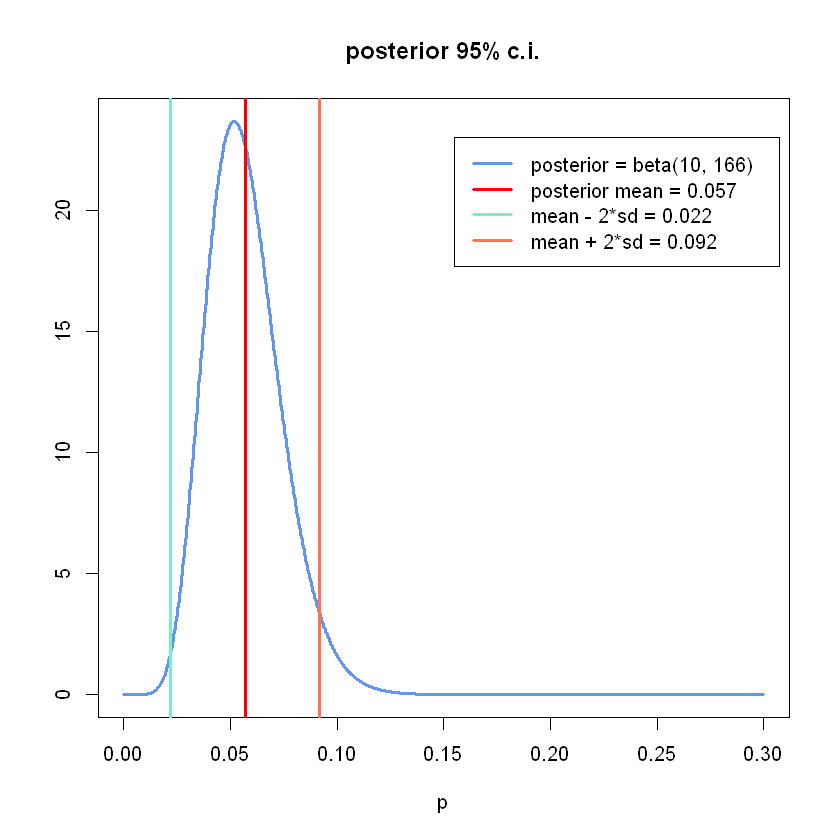

In [31]:
# credibility interval: once again we can exploit a 2 sigma gaussian approximation

m <- mean.posterior; s <- sqrt(var.posterior)
a <- m - 2*s; b <- m + 2*s

area <- integrate(posterior, a, b)$value
print(sprintf("area under the posterior between %.3f and %.3f = %.3f", a, b, area))

x <- seq(0, 0.3, length.out = 1000)
plot(x, posterior(x), type = "l", col = "cornflowerblue", lwd = 3, main = "posterior 95% c.i.", xlab = "p", ylab = "")
abline(v = m, col = "red", lwd = 2.5)
abline(v = m - 2*s, col = "aquamarine2", lwd = 2.5)
abline(v = m + 2*s, col = "coral1", lwd = 2.5)

legend(x = 0.155, y = 23, legend = c(sprintf("posterior = beta(%i, %i)", alpha.posterior, beta.posterior), sprintf("posterior mean = %.3f", mean.posterior), sprintf("mean - 2*sd = %.3f", m - 2*s), sprintf("mean + 2*sd = %.3f", m + 2*s)), lty = rep(1, 4), lwd = c(3, 2.5, 2.5, 2.5), col = c("cornflowerblue", "red", "aquamarine2", "coral1"))

### 3.8: frequentist vs bayesian hypothesis testing with $\alpha = 5\%$

[1] "since 0.1 is outside [0.022, 0.092] we reject the null hypothesis"


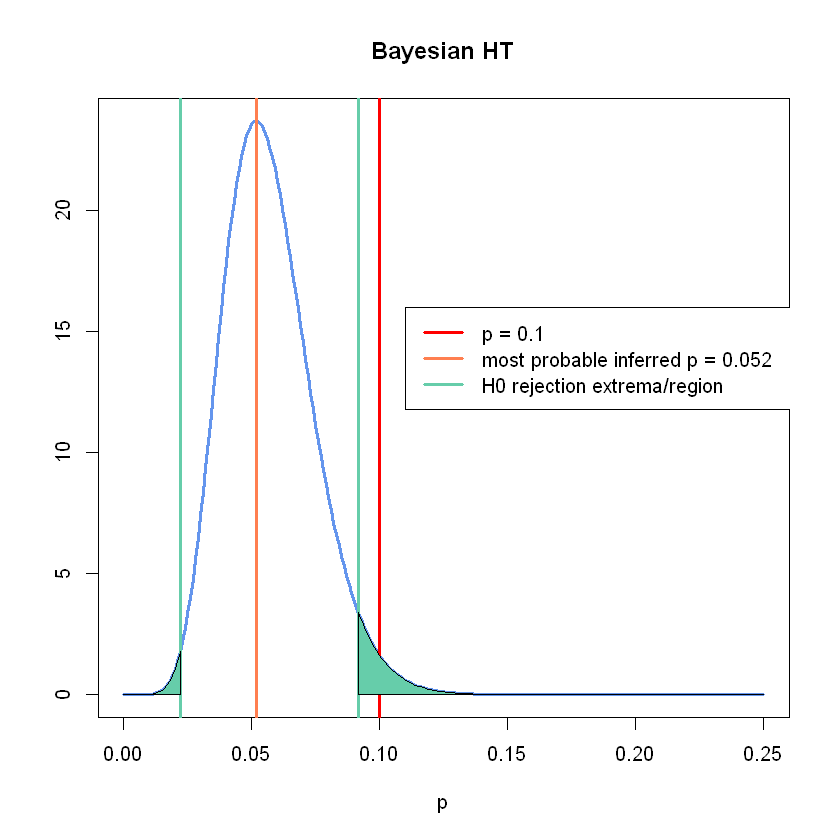

In [32]:
# Bayesian H.T.

p0 <- 0.1 # the value of p if H0 holds

if ((p0 <= a) | (b <= p0)) {
    print(sprintf("since %.1f is outside [%.3f, %.3f] we reject the null hypothesis", p0, a, b))
} else {
    print(sprintf("since %.1f is inside [%.3f, %.3f] we accept the null hypothesis", p0, a, b))
}

p.vector <- seq(0, 0.25, 0.001)
plot(p.vector, posterior(p.vector), type = "l", lwd = 3, col = "cornflowerblue", main = "Bayesian HT", xlab = "p", ylab = "")
abline(v = 0.1, lwd = 2.5, col = "red")
abline(v = mode.posterior, lwd = 2.5, col = "coral")
abline(v = a, col = "aquamarine3", lwd = 2.5)
abline(v = b, col = "aquamarine3", lwd = 2.5)

polygon(x = c(0, p.vector[p.vector <= a], a, a), y = c(0, posterior(p.vector[p.vector <= a]), posterior(a), 0), col = "aquamarine3")
polygon(x = c(b, b, p.vector[p.vector >= b], 0.25), y = c(0, posterior(b), posterior(p.vector[p.vector >= b]), 0), col = "aquamarine3")

legend(x = 0.11, y = 16, legend = c("p = 0.1", sprintf("most probable inferred p = %.3f", mode.posterior), "H0 rejection extrema/region"), lty = rep(1, 3), lwd = rep(3, 3), col = c("red", "coral", "aquamarine3"))

[1] "probability of observing y < 9 or > 25 with p = 0.1, n = 165: 0.0409"
[1] "since 0.0409 is less than 0.05 we reject the null hypothesis"


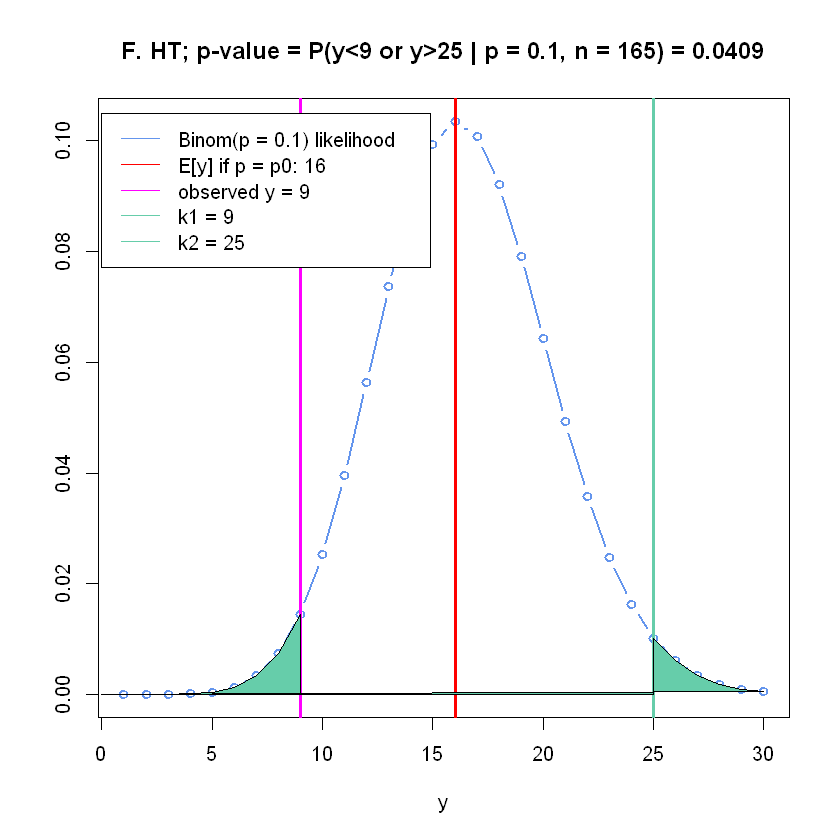

In [33]:
# Frequentist H.T.

exp.val <- round(p0*n)
delta <- 8
k1 <- exp.val - delta + 1; k2 <- exp.val + delta + 1
prob = pbinom(k2, size = n, prob = p0) - pbinom(k1, size = n, prob = p0) # P(k1 <= k <= k2) = P(k <= k2) - P(k <= k1)
p.value = 1 - prob # p-value = the probability that the observed k = y lies outside the acceptance region if H0 holds
# i.e. if the data comes from Binom(p = 0.1)

#print(abs(p.value - significance))

print(sprintf("probability of observing y < %i or > %i with p = %.1f, n = %i: %.4f", k1, k2, p0, n, p.value))

significance <- 0.05
if (p.value < significance) {
    print(sprintf("since %.4f is less than %.2f we reject the null hypothesis", p.value, significance))
} else {
    print(sprintf("since %.4f is greater than or equal to %.2f we accept the null hypothesis", p.value, significance))
}

y.vector <- 1:30 
fht.vector <- dbinom(y.vector, size = n, prob = p0)

plot(y.vector, fht.vector, type = "b", col = "cornflowerblue", lwd = 2, xlab = "y", ylab = "", main = sprintf("F. HT; p-value = P(y<%i or y>%i | p = %.1f, n = %i) = %.4f", k1, k2, p0, n, p.value))

abline(v = k1, col = "aquamarine3", lwd = 2.5); abline(v = k2, col = "aquamarine3", lwd = 2.5)
abline(v = y, col = "magenta", lwd = 2.5)

abline(v = exp.val, col = "red", lwd = 2.5)

polygon(x = c(0, y.vector[y.vector <= k1], k1), y = c(0, fht.vector[y.vector <= k1], 0), col = "aquamarine3")
polygon(x = c(k2, y.vector[y.vector >= k2], 0), y = c(0, fht.vector[y.vector >= k2], 0), col = "aquamarine3")

legend(x = 0, y = 0.105, legend = c(sprintf("Binom(p = %.1f) likelihood", p0), sprintf("E[y] if p = p0: %i", exp.val), sprintf("observed y = %i", y), sprintf("k1 = %i", k1), sprintf("k2 = %i", k2)), lty = rep(1, 5), col = c("cornflowerblue", "red", "magenta", rep("aquamarine3", 2)))

That this second time $H_0$ was rejected with both approaches is an intuitive result: this time we had a larger dataset and yet observed less successes, and this intuitively suggests a lower $p$.

Notice that hypothesis testing done this way is at least in part arbitrary; if for example in the above cell we change the right extremum from 25 to 24 the p-value jumps from 0.0409 to 0.511, hence *even with the same (arbitrary) significance the null hypothesis changes from rejected to accepted!*           
This is inevitable; there is no unique "best" way to design the acceptance/rejection region, because there are multiple choices thereof such that the resulting p-value is slightly larger/smaller than $\alpha$.